In [ ]:
!pip install dscribe ase scikit-learn xgboost lightgbm

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML_domain_of_applicability/LI-ion batteries/work/NCM-ML')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
data = pd.read_csv('NMC_numerical_new.csv')

# N-gram feature vector creation

In [ ]:
def create_pseudo_formula(row):
    """
    Generates a pseudo-formula string based on element ratios.
    :param row: A single row of the DataFrame.
    :return: A string representing the pseudo-formula.
    """
    formula = f"Li{row['Li']:.2f}Ni{row['Ni']:.2f}Co{row['Co']:.2f}Mn{row['Mn']:.2f}M{row['M']:.2f}"
    return formula

# Apply the function to create pseudo-formula strings
data['pseudo_formula'] = data.apply(create_pseudo_formula, axis=1)

def generate_ngrams(data, n=2):
    """
    Generates n-gram features for compositional data.
    :param data: List of pseudo-formulas.
    :param n: n-gram size.
    :return: n-gram feature matrix and feature labels.
    """
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n))
    ngram_features = vectorizer.fit_transform(data)
    return ngram_features.toarray(), vectorizer.get_feature_names_out()

# Generate n-gram features from pseudo-formulas
ngram_features, ngram_labels = generate_ngrams(data['pseudo_formula'], n=2)

print(f"N-gram Features Shape: {ngram_features.shape}")
print(f"Sample Features: {ngram_labels[:10]}")  # Prints feature labels (e.g., 'Li', 'Ni', 'Co')


N-gram Features Shape: (168, 115)
Sample Features: ['.0' '.1' '.2' '.3' '.4' '.5' '.6' '.7' '.8' '.9']


# error functions

In [ ]:
def calculate_errors(y_train, y_train_pred, y_test, y_test_pred):
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    return rmse_train, rmse_test, r2_test

# Plotting functions

In [ ]:
def plot_IC_curve(y_IC_train, y_train_pred, y_IC_test, y_test_pred, rmse_train, rmse_test, r2_test, model_name):
    results_train = pd.DataFrame({
        "Experimental": y_IC_train,
        "Predicted": y_train_pred
    })
    results_test = pd.DataFrame({
        "Experimental": y_IC_test,
        "Predicted": y_test_pred
    })

    plt.figure(figsize=(8, 8))
    plt.axis([50, 330, 50, 330])

    plt.scatter(x=results_train["Experimental"], y=results_train["Predicted"], c='deepskyblue', label='Training')
    plt.scatter(x=results_test["Experimental"], y=results_test["Predicted"], c='blue', label='Test')

    plt.plot([50, 360], [50, 360], label='True Line', color='red', linewidth=2)

    plt.legend(loc='lower right')
    plt.xlabel(r'Experimental Initial Charge Capacity (IC) (mAh/g)')
    plt.ylabel(r'Predicted Initial Charge Capacity (IC) (mAh/g)')
    plt.title(f'{model_name} - IC Results Plot')

    plt.text(60, 260, f"$RMSE_{{train}} = {rmse_train:.2f} \, mAh/g$\n" +
            f"$RMSE_{{test}} = {rmse_test:.2f} \, mAh/g$\n" +
            f"$R^2_{{test}} = {r2_test:.2f}$", fontsize=12)

    plt.savefig(f'{model_name}-IC-Predicted-vs-Test.png', dpi=1000)

    plt.show()

In [ ]:
def plot_EC_curve(y_EC_train, y_train_pred, y_EC_test, y_test_pred, rmse_train, rmse_test, r2_test, model_name):
    results_train = pd.DataFrame({
        "Experimental": y_EC_train,
        "Predicted": y_train_pred
    })
    results_test = pd.DataFrame({
        "Experimental": y_EC_test,
        "Predicted": y_test_pred
    })

    plt.figure(figsize=(8, 8))
    plt.axis([50, 330, 50, 330])

    plt.scatter(x=results_train["Experimental"], y=results_train["Predicted"], c='deepskyblue', label='Training')
    plt.scatter(x=results_test["Experimental"], y=results_test["Predicted"], c='blue', label='Test')

    plt.plot([50, 360], [50, 360], label='True Line', color='red', linewidth=2)

    plt.legend(loc='lower right')
    plt.xlabel(r'Experimental 50th cycle discharge Capacity (EC) (mAh/g)')
    plt.ylabel(r'Predicted 50th cycle discharge Capacity (EC) (mAh/g)')
    plt.title(f'{model_name} - EC Results Plot')

    plt.text(60, 260, f"$RMSE_{{train}} = {rmse_train:.2f} \, mAh/g$\n" +
            f"$RMSE_{{test}} = {rmse_test:.2f} \, mAh/g$\n" +
            f"$R^2_{{test}} = {r2_test:.2f}$", fontsize=12)

    plt.savefig(f'{model_name}-EC-Predicted-vs-Test.png', dpi=1000)

    plt.show()

# Splitting the data

In [ ]:
numerical_features = data.iloc[:, 5:20].values
targets_ic = data['IC'].values
targets_ec = data['EC'].values

X_combined = np.hstack([ngram_features, numerical_features])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train_ic, y_test_ic = train_test_split(X_combined, targets_ic, test_size=0.2, random_state=42)
_, _, y_train_ec, y_test_ec = train_test_split(X_combined, targets_ec, test_size=0.2, random_state=42)

# Random Forest

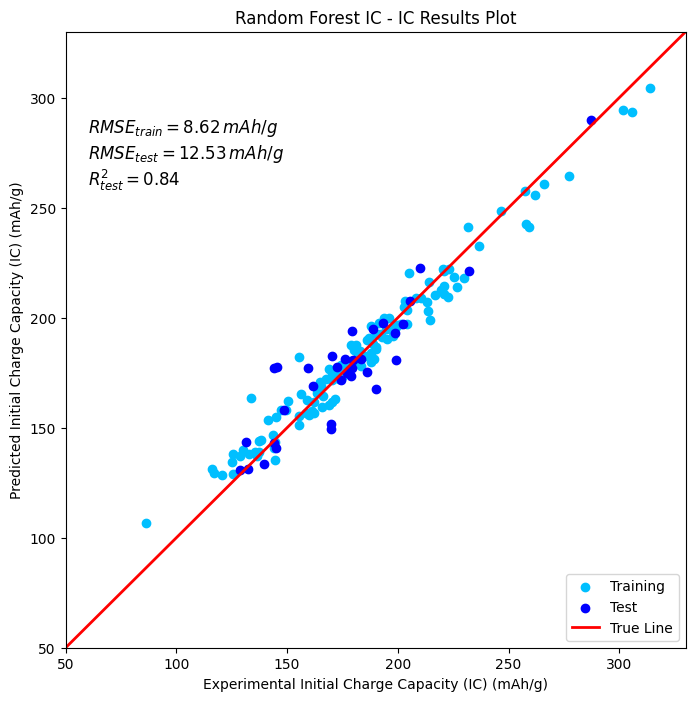

Random Forest IC - RMSE_train: 8.62, RMSE_test: 12.53, R²: 0.84


In [ ]:
rf_ic = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_ic.fit(X_train, y_train_ic)

y_pred_ic_train = rf_ic.predict(X_train)
y_pred_ic = rf_ic.predict(X_test)

rmse_train_ic, rmse_ic, r2_ic = calculate_errors(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic)
plot_IC_curve(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic, rmse_train_ic, rmse_ic, r2_ic, "Random Forest IC")

print(f"Random Forest IC - RMSE_train: {rmse_train_ic:.2f}, RMSE_test: {rmse_ic:.2f}, R²: {r2_ic:.2f}")

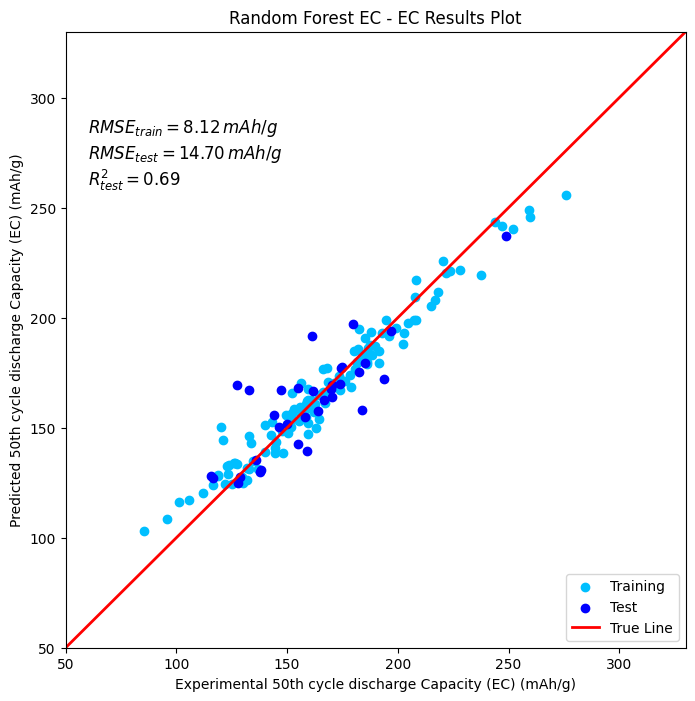

Random Forest EC - RMSE_train: 8.12, RMSE_test: 14.70, R²: 0.69


In [ ]:
rf_ec = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_ec.fit(X_train, y_train_ec)

y_pred_ec_train = rf_ec.predict(X_train)
y_pred_ec = rf_ec.predict(X_test)

rmse_train_ec, rmse_test_ec, r2_ec = calculate_errors(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec)
plot_EC_curve(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec, rmse_train_ec, rmse_test_ec, r2_ec, "Random Forest EC")

print(f"Random Forest EC - RMSE_train: {rmse_train_ec:.2f}, RMSE_test: {rmse_test_ec:.2f}, R²: {r2_ec:.2f}")

# Xgboost

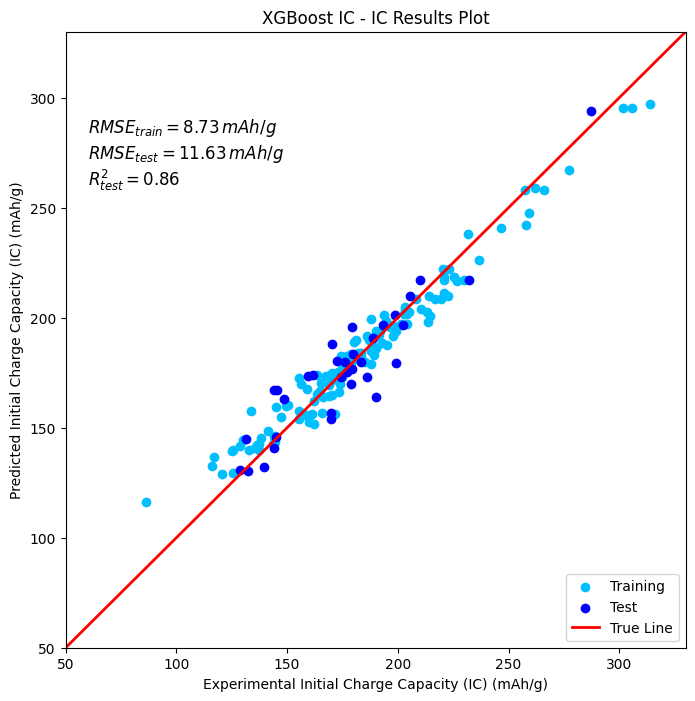

XGBoost IC - RMSE train: 8.73, RMSE test: 11.63, R²: 0.86


In [ ]:
xgb_ic = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.03, random_state=42)
xgb_ic.fit(X_train, y_train_ic)

y_pred_ic_train = xgb_ic.predict(X_train)
y_pred_ic = xgb_ic.predict(X_test)

rmse_train_ic, rmse_ic, r2_ic = calculate_errors(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic)
plot_IC_curve(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic, rmse_train_ic, rmse_ic, r2_ic, "XGBoost IC")

print(f"XGBoost IC - RMSE train: {rmse_train_ic:.2f}, RMSE test: {rmse_ic:.2f}, R²: {r2_ic:.2f}")

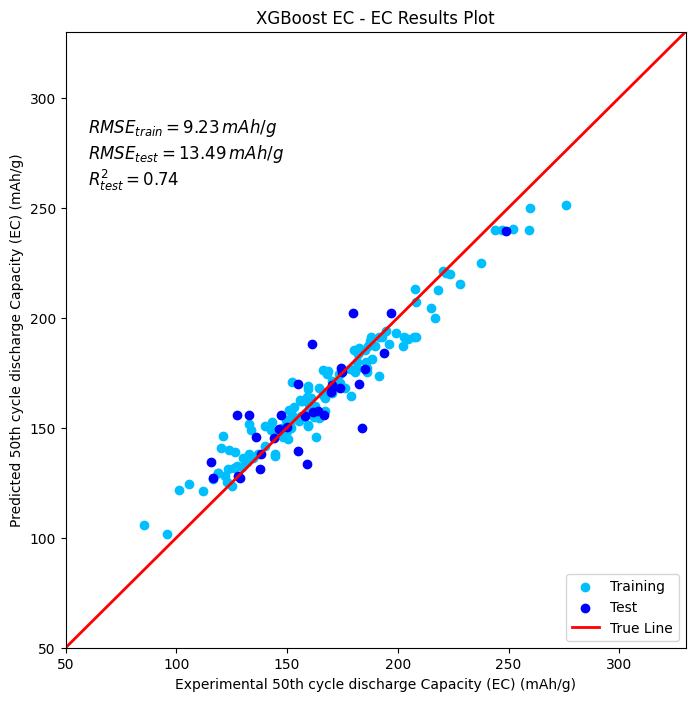

XGBoost EC - RMSE train: 9.23, RMSE test: 13.49, R²: 0.74


In [ ]:
xgb_ec = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.03, random_state=42)
xgb_ec.fit(X_train, y_train_ec)

y_pred_ec_train = xgb_ec.predict(X_train)
y_pred_ec = xgb_ec.predict(X_test)

rmse_train_ec, rmse_ec, r2_ec = calculate_errors(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec)
plot_EC_curve(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec, rmse_train_ec, rmse_ec, r2_ec, "XGBoost EC")

print(f"XGBoost EC - RMSE train: {rmse_train_ec:.2f}, RMSE test: {rmse_ec:.2f}, R²: {r2_ec:.2f}")

# LGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 35
[LightGBM] [Info] Start training from score 185.647687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

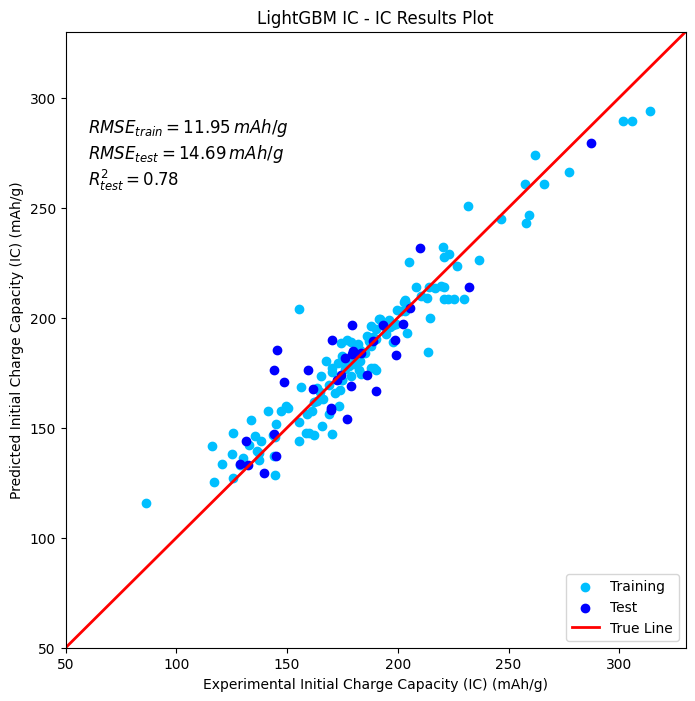

LightGBM IC - RMSE train: 11.95, RMSE test: 14.69, R²: 0.78


In [ ]:
lgbm_ic = LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)
lgbm_ic.fit(X_train, y_train_ic)

y_pred_ic_train = lgbm_ic.predict(X_train)
y_pred_ic = lgbm_ic.predict(X_test)

rmse_train_ic, rmse_ic, r2_ic = calculate_errors(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic)
plot_IC_curve(y_train_ic, y_pred_ic_train, y_test_ic, y_pred_ic, rmse_train_ic, rmse_ic, r2_ic, "LightGBM IC")

print(f"LightGBM IC - RMSE train: {rmse_train_ic:.2f}, RMSE test: {rmse_ic:.2f}, R²: {r2_ic:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 35
[LightGBM] [Info] Start training from score 166.005895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

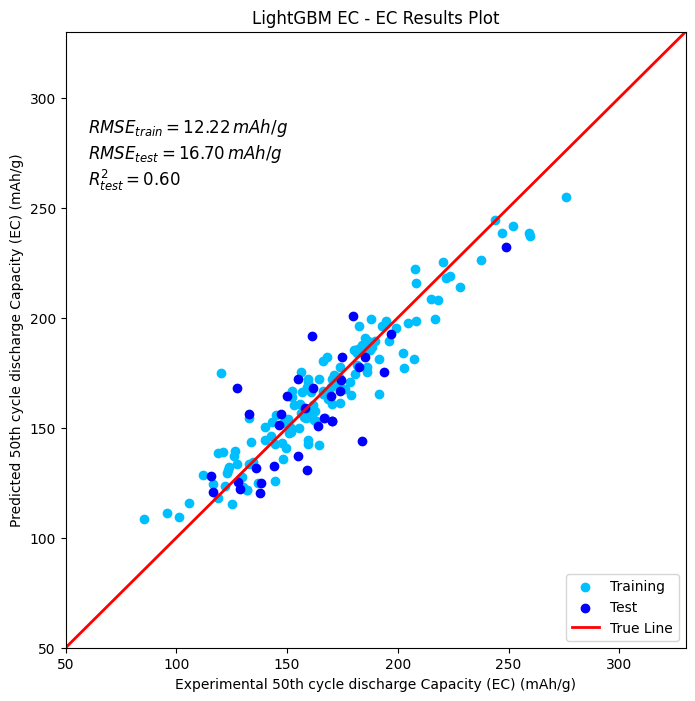

LightGBM EC - RMSE train: 12.22, RMSE test: 16.70, R²: 0.60


In [ ]:
lgbm_ec = LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)
lgbm_ec.fit(X_train, y_train_ec)

y_pred_ec_train = lgbm_ec.predict(X_train)
y_pred_ec = lgbm_ec.predict(X_test)

rmse_train_ec, rmse_ec, r2_ec = calculate_errors(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec)
plot_EC_curve(y_train_ec, y_pred_ec_train, y_test_ec, y_pred_ec, rmse_train_ec, rmse_ec, r2_ec, "LightGBM EC")

print(f"LightGBM EC - RMSE train: {rmse_train_ec:.2f}, RMSE test: {rmse_ec:.2f}, R²: {r2_ec:.2f}")

# SVR

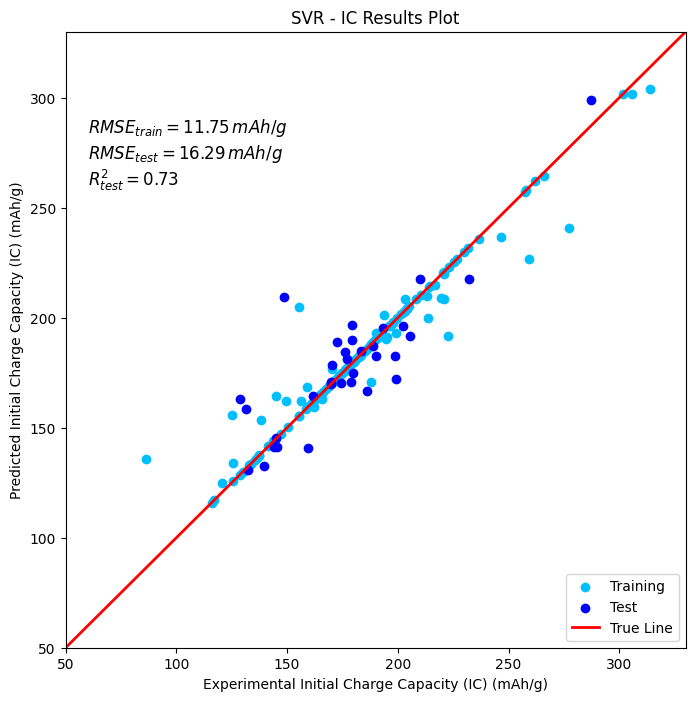

In [ ]:
svr_model = SVR(kernel='rbf', C=80, gamma=0.01, epsilon=0.02)
svr_model.fit(X_train, y_train_ic)

y_train_pred = svr_model.predict(X_train)
y_test_pred = svr_model.predict(X_test)

rmse_train, rmse_test, r2_test = calculate_errors(y_train_ic, y_train_pred, y_test_ic, y_test_pred)
plot_IC_curve(y_train_ic, y_train_pred, y_test_ic, y_test_pred, rmse_train, rmse_test, r2_test, "SVR")

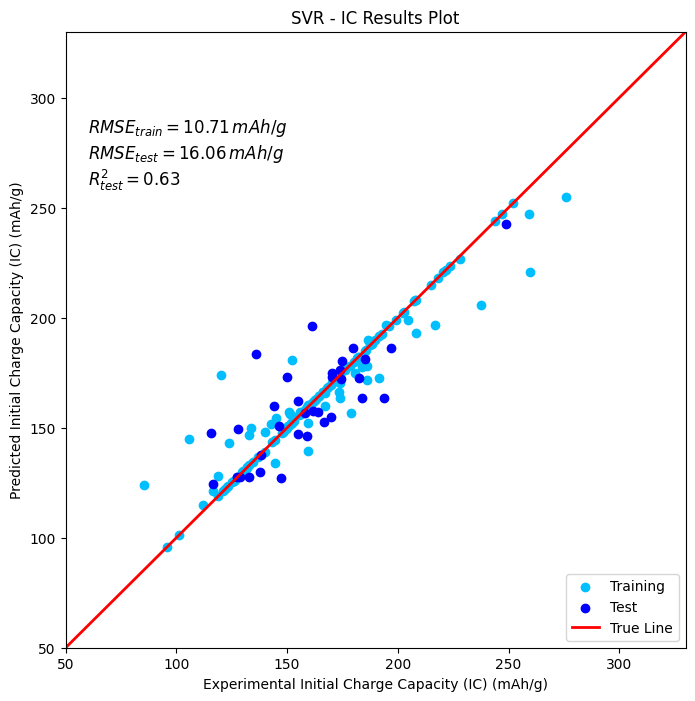

In [ ]:
svr_model = SVR(kernel='rbf', C=80, gamma=0.01, epsilon=0.02)
svr_model.fit(X_train, y_train_ec)

y_train_pred = svr_model.predict(X_train)
y_test_pred = svr_model.predict(X_test)

rmse_train, rmse_test, r2_test = calculate_errors(y_train_ec, y_train_pred, y_test_ec, y_test_pred)
plot_IC_curve(y_train_ec, y_train_pred, y_test_ec, y_test_pred, rmse_train, rmse_test, r2_test, "SVR")